#A file letöltése

In [ ]:
import requests
import re

response = requests.get("https://www.gutenberg.org/cache/epub/41504/pg41504.txt")

# sikeres volt?
if response.status_code == 200:
    text_content = response.text
else:
    print(f"Failed to retrieve the file. Status code: {response.status_code}")

kelt_regex = "^\([^)]+\)$"
line_regex = "^[ ]{2,}[^ ].*$"

original_lines = text_content.splitlines()[84:42420]
print(original_lines[:30])

# azért itt definiálom, hogy lefusson a kiiratás
joined_text = []
poems = []

print(len(text_content))

['JÁNOS VITÉZ.', '', 'I.', '', '  Tüzesen süt le a nyári nap sugára', '  Az ég tetejérol a juhászbojtárra.', '  Fölösleges dolog, sütnie oly nagyon,', '  A juhásznak úgy is nagy melege vagyon.', '', '  Szerelem tüze ég fiatal szivében,', '  Ugy legelteti a nyájt a faluvégen.', '  Faluvégen nyája mig szerte legelész,', '  O addig subáján a fuben heverész.', '', '  Tenger virág nyílik tarkán körülötte,', '  De o a virágra szemét nem vetette;', '  Egy kohajtásnyira foly tole a patak,', '  Bámuló szemei oda tapadtanak.', '', '  De nem ám a patak csillámló habjára,', '  Hanem a patakban egy szoke kis lyányra,', '  A szoke kis lyánynak karcsu termetére,', '  Szép hosszú hajára, gömbölyu keblére.', '', '  Kis leány szoknyája térdig föl van hajtva,', "  Mivelhogy ruhákat mos a fris patakba';", '  Kilátszik a vizbol két szép térdecskéje', '  Kukoricza Jancsi gyönyöruségére.', '', '  Mert a pázsit fölött heverészo juhász']
1145175


# I. Verzió: folyó szöveg

In [ ]:
joined_text = []

for line in original_lines:
  if line.strip() == "":
    if joined_text and joined_text[-1].strip() != "":
      joined_text.append("")
  elif re.search(line_regex, line):
    joined_text.append(line.strip())

# karakterek szama (917302)
print(len("".join(joined_text)))
# sorok szama (37682)
print(len(joined_text))

917302
37682


#II. Verzió: Struktúrált formátum

##Segéd funkciók

In [ ]:
# segédkód a címek kezelésére
# a cimből az utolsó pont utáni részt le kell venni, kivéve ha .. vagy ...-ra végződik.
def smartsplit(input_string):
    first_part, sep, _ = input_string.rpartition('.')
    if (len(first_part) > 0 and first_part[-1] == '.'):
        return first_part+sep
    else:
      return first_part if sep else input_string

In [ ]:
# versszakok szétvágása
split_amounts = [8, 6, 5, 4]
def split_verses_func(verse):
  if len(verse) > 8:
    for amount in split_amounts[:-1]:
      if len(verse) % amount == 0:
        return ["\n".join(verse[i:i+amount]) for i in range(0, len(verse), amount)]
    # if could not be split, just split it into groups of 4, and save the rest
    return ["\n".join(verse[i:i+split_amounts[-1]]) for i in range(0, len(verse), split_amounts[-1])]
  else:
    return ["\n".join(verse)]

##Fő kód

In [ ]:
verses = []
verse = []
poems = []
original_poems = []
space_count = 0

# minden vers neve egyedi kell hogy legyen
already_seen = set()

for i, line in enumerate(original_lines):
    # ha egy sor space, akkor ha volt előtte versszak, akkor elválaszt
    if line.strip() == "":
        space_count += 1
        if verse:
          verses.append(verse)
          verse = []
    else:
      loop_at_edges = i == len(original_lines)-1 or i == 0
      at_end_of_poem = re.search(kelt_regex, line.strip()) and original_lines[i+1] == ""

      if space_count >= 2 or loop_at_edges or at_end_of_poem:
          if verse:
            verses.append(verse)

          if verses:
            if title not in already_seen:
              original_verses = []
              split_verses = []

              for verse in verses:
                original_verses.append("\n".join(verse))
                split_verses.extend(split_verses_func(verse))
              if re.search(kelt_regex, line.strip()):
                origin = line.strip()[1:-2]
              else:
                origin = "Ismeretlen"

              poems.append({"title": title, "body": split_verses, "origin": origin})
              original_poems.append({"title": title, "body": original_verses, "origin": origin})

            already_seen.add(title)

          verses = []
          verse = []
          title = smartsplit(line.strip())
      else:
        if re.search(line_regex, line):
          verse.append("  "+ line.strip())
        elif verse:
          verses.append(verse)
          verse = []
      space_count = 0

# 805-nek kell lennie
print(len(poems))

805


#Megjelenítés

In [ ]:
def to_roman_numeral(value):
    roman_map = {                                   # 1
        1: "I", 5: "V",
        10: "X", 50: "L",
        100: "C", 500: "D",
        1000: "M",
    }
    result = ""
    remainder = value

    for i in sorted(roman_map.keys(), reverse=True):# 2
        if remainder > 0:
            multiplier = i
            roman_digit = roman_map[i]

            times = remainder // multiplier         # 3
            remainder = remainder % multiplier      # 4
            result += roman_digit * times           # 4

    return result

In [ ]:
def split_poems(poems):
    split_poems_list = []
    for poem in poems:
        verses = poem["body"]
        for i in range(0, len(verses), 4):
            # Create a new poem dictionary with at most 4 verses
            new_poem = {
                "title": poem["title"] if "title" in poem else "Untitled",
                "author": poem["author"] if "author" in poem else "Unknown",
                "body": verses[i:i+4]
            }
            split_poems_list.append(new_poem)
    return split_poems_list

split_delimiter = 4
split_poems_list = []
for poem in poems:
  if len(poem["body"]) > split_delimiter:
    verses = poem["body"]
    for i in range(0, len(verses), split_delimiter):
      split_poems_list.append({"title": poem["title"] + ' ' + to_roman_numeral(i // split_delimiter), "body": verses[i:i+split_delimiter], "origin": poem["origin"]})
  else:
    split_poems_list.append(poem)
print(len(split_poems_list))

2032


In [ ]:
import numpy as np
print(np.percentile([len('\n'.join(poem["body"]).splitlines()) for poem in poems], 95))

80.0


In [ ]:
print(len(poems))
body_count = sum(len('\n'.join(poem["body"]).splitlines()) for poem in poems)

verse_count = sum(len(poem["body"]) for poem in poems)
print(verse_count)

filtered_body_count = sum(len('\n'.join(poem["body"]).splitlines()) for poem in poems if len('\n'.join(poem["body"]).splitlines()) > 80)

print(body_count, filtered_body_count)

805
6827
32120 11702


In [ ]:
for poem in split_poems_list[:100]:
  print(poem["title"])

JÁNOS VITÉZ 
JÁNOS VITÉZ I
JÁNOS VITÉZ II
JÁNOS VITÉZ III
JÁNOS VITÉZ IIII
JÁNOS VITÉZ V
JÁNOS VITÉZ VI
JÁNOS VITÉZ VII
JÁNOS VITÉZ VIII
JÁNOS VITÉZ VIIII
JÁNOS VITÉZ X
JÁNOS VITÉZ XI
JÁNOS VITÉZ XII
JÁNOS VITÉZ XIII
JÁNOS VITÉZ XIIII
JÁNOS VITÉZ XV
JÁNOS VITÉZ XVI
JÁNOS VITÉZ XVII
JÁNOS VITÉZ XVIII
JÁNOS VITÉZ XVIIII
JÁNOS VITÉZ XX
JÁNOS VITÉZ XXI
JÁNOS VITÉZ XXII
JÁNOS VITÉZ XXIII
JÁNOS VITÉZ XXIIII
JÁNOS VITÉZ XXV
JÁNOS VITÉZ XXVI
JÁNOS VITÉZ XXVII
JÁNOS VITÉZ XXVIII
JÁNOS VITÉZ XXVIIII
JÁNOS VITÉZ XXX
JÁNOS VITÉZ XXXI
JÁNOS VITÉZ XXXII
JÁNOS VITÉZ XXXIII
JÁNOS VITÉZ XXXIIII
JÁNOS VITÉZ XXXV
JÁNOS VITÉZ XXXVI
JÁNOS VITÉZ XXXVII
JÁNOS VITÉZ XXXVIII
JÁNOS VITÉZ XXXVIIII
JÁNOS VITÉZ XXXX
JÁNOS VITÉZ XXXXI
JÁNOS VITÉZ XXXXII
JÁNOS VITÉZ XXXXIII
JÁNOS VITÉZ XXXXIIII
JÁNOS VITÉZ XXXXV
JÁNOS VITÉZ XXXXVI
JÁNOS VITÉZ XXXXVII
JÁNOS VITÉZ XXXXVIII
JÁNOS VITÉZ XXXXVIIII
JÁNOS VITÉZ L
JÁNOS VITÉZ LI
JÁNOS VITÉZ LII
JÁNOS VITÉZ LIII
JÁNOS VITÉZ LIIII
JÁNOS VITÉZ LV
JÁNOS VITÉZ LVI
JÁNOS VITÉZ LV

698.94


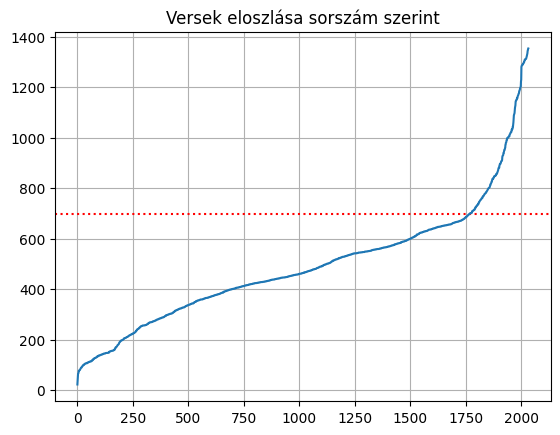

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

sum_list = sorted([sum([len(verse) for verse in poem["body"]]) for poem in split_poems_list])

percentile = np.percentile(sum_list, 87)
print(percentile)
plt.axhline(y = percentile, color = 'r', linestyle = 'dotted')
plt.plot(sum_list)
plt.title("Versek eloszlása sorszám szerint")
plt.grid()
plt.show()

In [ ]:
def display_pie_chart(list_of_poems, delimiter, title, base_color):

  def autopct(pct):
    return f'{pct:.1f}%' if pct > 2 else ''

  length_list = {}

  for poem in list_of_poems:
    verse_length = len(poem["body"][0].splitlines())
    if verse_length in length_list:
      length_list[verse_length] += 1
    else:
      length_list[verse_length] = 1

  x = sorted(length_list.keys())[:delimiter]
  y = [length_list[index] for index in x]

  others_sum = sum(length_list[key] for key in sorted(length_list.keys())[delimiter:])
  if (others_sum > 0):
    x.append(f"{x[-1]}+")
    y.append(others_sum)

  x.reverse()
  y.reverse()

  max_value = max(y)
  explode_list = [0.01 + float(value) * 0.0001 for value in y]
  colors_list = [(*base_color[:3], min(1, 0.25 + (value / max_value) * 2)) for value in y]

  plt.pie(
    y,
    labels=x,
    autopct=lambda pct: autopct(pct),
    startangle=90,
    explode=explode_list,
    colors=colors_list,
    wedgeprops = {'linewidth': 0.7, 'antialiased': True}
  )

  plt.title(title)
  plt.show()

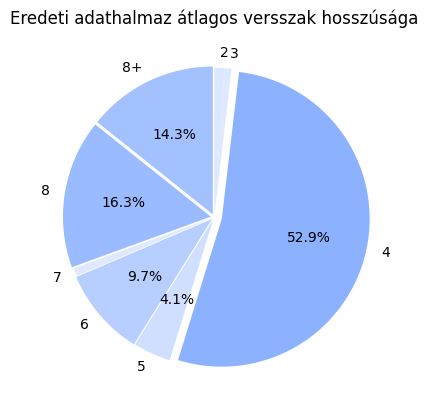

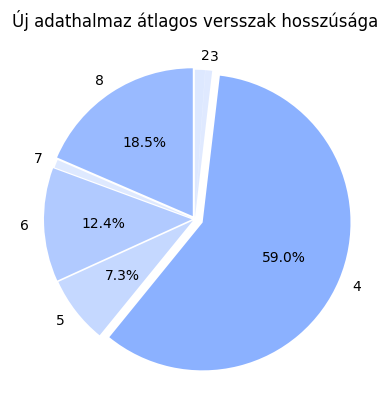

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
base_color = to_rgba((139 / 255, 177 / 255, 255 / 255, 1))

display_pie_chart(original_poems, 7, "Eredeti adathalmaz átlagos versszak hosszúsága", base_color)
display_pie_chart(poems, 7, "Új adathalmaz átlagos versszak hosszúsága", base_color)

#Exportálás

In [ ]:
import json
import os
import shutil

# Define a folder to store the output files
output_folder = "results"

# If the folder exists, delete it and all its contents
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Create a fresh output folder
os.makedirs(output_folder)

# # I. Verzió mentése
# if joined_text:
#   print(len(joined_text))
#   with open(os.path.join(output_folder, f"Petofi_corpus_joined.txt"), "w", encoding="utf-8") as file:
#     file.write("\n".join(joined_text))

# # II. Verzió mentése
# if poems:
#   with open(os.path.join(output_folder, f"Petofi_corpus.json"), "w", encoding="utf-8") as file:
#     json.dump(poems, file, ensure_ascii=False)

# II. Verzió mentése
if split_poems_list:
  with open(os.path.join(output_folder, f"Petofi_corpus_split.json"), "w", encoding="utf-8") as file:
    json.dump(split_poems_list, file, ensure_ascii=False)